In [232]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import cv2
import numpy as np
import random

from helpers import *
from unet_model import multi_unet_model, jacard_coef  
from skimage.io import imread, imshow
from tqdm import tqdm
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image, ImageOps

In [233]:
print(tf. __version__) 
print(device_lib.list_local_devices())

2.10.1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 292859625533453404
xla_global_id: -1
]


In [234]:
ROOT_DIRECTORY = 'training/'
PATCH_SIZE = 256
NUMBER_IMAGES_TRAINING = 100
TRAIN_PATH_IMAGES = 'training/images/'
TRAIN_PATH_GROUNDTRUTH = 'training/groundtruth/'
TEST_PATH = 'test_set_images/'

In [235]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
position = 0
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split("/")[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in tqdm(enumerate(images), total=NUMBER_IMAGES_TRAINING):
            if i+1 > NUMBER_IMAGES_TRAINING:
                break
            if image_name.endswith(".png"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image) 
                #Extract patches from each image
                #print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds. 
                        image_dataset.append(single_patch_img)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.16it/s]


In [236]:
mask_dataset = []  
position = 0
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split("/")[-1]
    if dirname == 'groundtruth':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in tqdm(enumerate(masks), total=NUMBER_IMAGES_TRAINING):  
            if i+1 > NUMBER_IMAGES_TRAINING:
                break
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                #print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 1), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.   
                        mask_dataset.append(single_patch_mask) 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.12it/s]


In [292]:
# Test images
test_ids = os.listdir(TEST_PATH)
test_dataset = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    image = Image.open(path+"/"+ id_+".png")
    image = resize_with_padding(image, (768, 768))
    image = np.array(image)  #Read each image as BGR
    #print(image.shape)
    SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
    SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
    image = Image.fromarray(image)
    image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
    #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
    image = np.array(image) 
    #Extract patches from each image
    #print("Now patchifying image:", path+"/"+image_name)
    patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]

            #Use minmaxscaler instead of just dividing by 255. 
            single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

            #single_patch_img = (single_patch_img.astype('float32')) / 255. 
            single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds. 
            test_dataset.append(single_patch_img)

print('Done!')

Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.72it/s]

Done!


In [278]:
# Test images
test_ids = os.listdir(TEST_PATH)
test_len = len(test_ids)*14

test_dataset = np.zeros((test_len, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
PATCHES = 14
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    imgs = imread(path + '/' + id_ + '.png')
    imgs = split_into_patches(imgs,256)
    for i, img in enumerate(imgs):
        test_dataset[n*PATCHES + i] = img

print('Done!')

Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.51it/s]

Done!


In [274]:
print(test_dataset.shape)

(750, 256, 256, 3)


In [293]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset, dtype=np.bool_)
test_dataset = np.array(test_dataset)

In [294]:
print(image_dataset.shape)
print(mask_dataset.shape)
print(test_dataset.shape)

(2500, 256, 256, 3)
(2500, 256, 256, 1)
(450, 256, 256, 3)


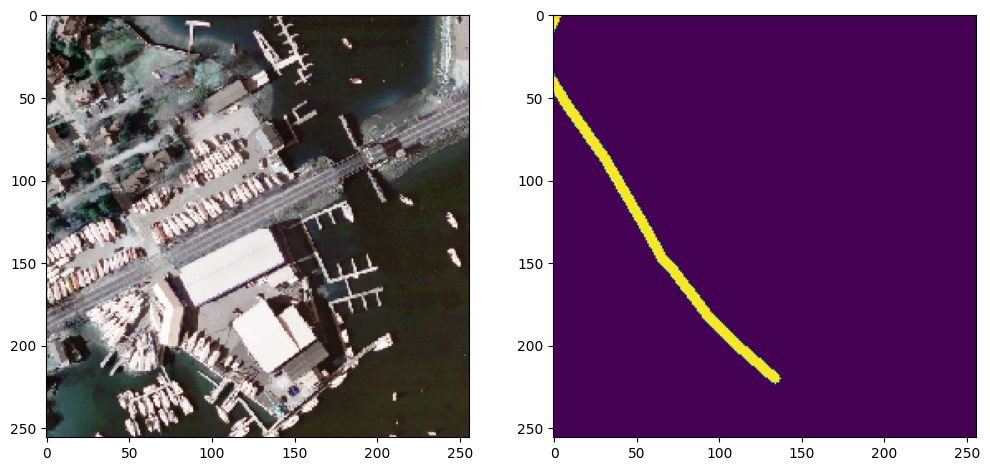

In [241]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 1)))
plt.show()

In [242]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

In [243]:
print(X_train.shape)

(2000, 256, 256, 3)


In [244]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_4 (Lambda)              (None, 256, 256, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 256, 256, 16  448         ['lambda_4[0][0]']               
                                )                                                                 
                                                                                            

In [76]:
# X_train = X_train[:100]
# y_train = y_train[:100]

In [79]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

model.fit(X_train, y_train,
            batch_size = 16, 
            verbose=1, 
            epochs=10, 
            validation_data=(X_test, y_test), 
            shuffle=False,
            callbacks=callbacks)

Epoch 1/10
125/125 [==============================] - 463s 4s/step - loss: 0.2126 - accuracy: 0.9557 - jacard_coef: 0.0259 - val_loss: 0.1955 - val_accuracy: 0.9500 - val_jacard_coef: 0.0240
Epoch 2/10
125/125 [==============================] - 448s 4s/step - loss: 0.1711 - accuracy: 0.9558 - jacard_coef: 0.0348 - val_loss: 0.1845 - val_accuracy: 0.9500 - val_jacard_coef: 0.0416
Epoch 3/10
125/125 [==============================] - 447s 4s/step - loss: 0.1608 - accuracy: 0.9558 - jacard_coef: 0.0506 - val_loss: 0.1719 - val_accuracy: 0.9500 - val_jacard_coef: 0.0608
Epoch 4/10
125/125 [==============================] - 450s 4s/step - loss: 0.1454 - accuracy: 0.9558 - jacard_coef: 0.0846 - val_loss: 0.1391 - val_accuracy: 0.9502 - val_jacard_coef: 0.1524
Epoch 5/10
125/125 [==============================] - 447s 4s/step - loss: 0.1085 - accuracy: 0.9638 - jacard_coef: 0.2120 - val_loss: 0.1023 - val_accuracy: 0.9653 - val_jacard_coef: 0.2780
Epoch 6/10
125/125 [=========================

32/32 [==============================] - 27s 847ms/step


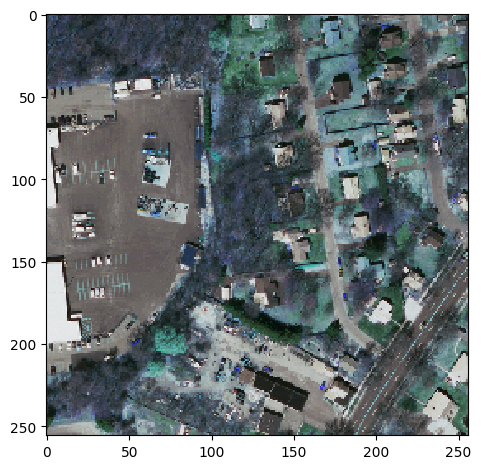

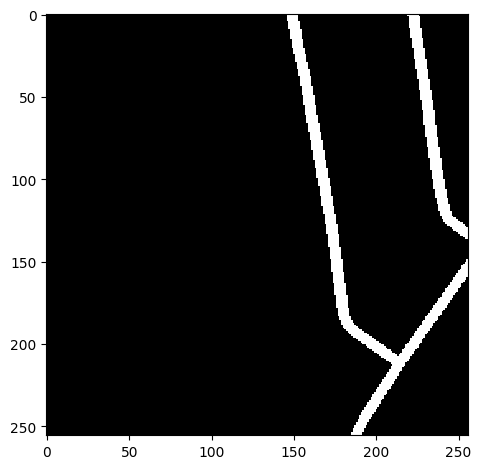

C:\Users\Mateo Echeverry\anaconda3\envs\hola\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


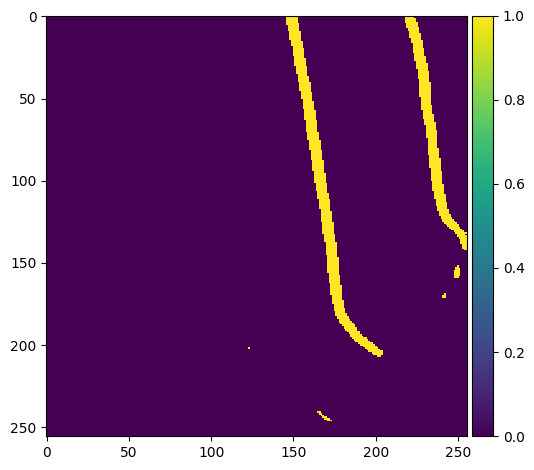

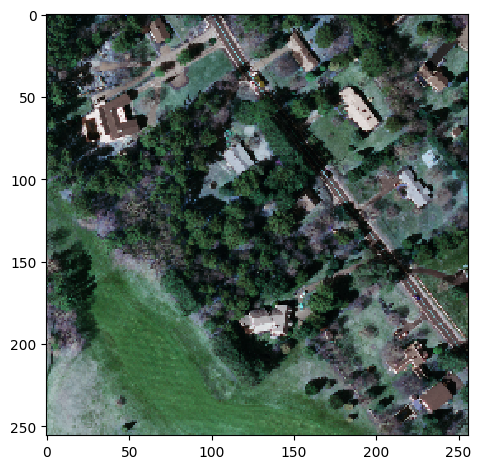

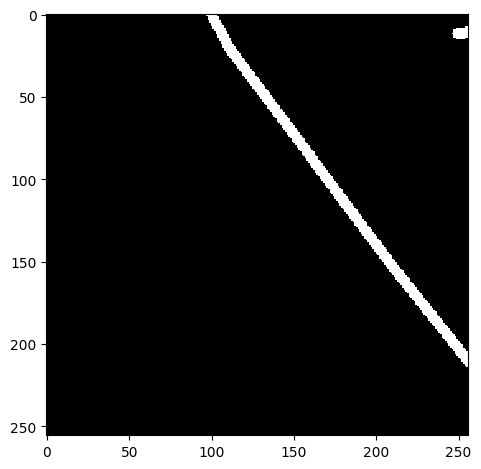

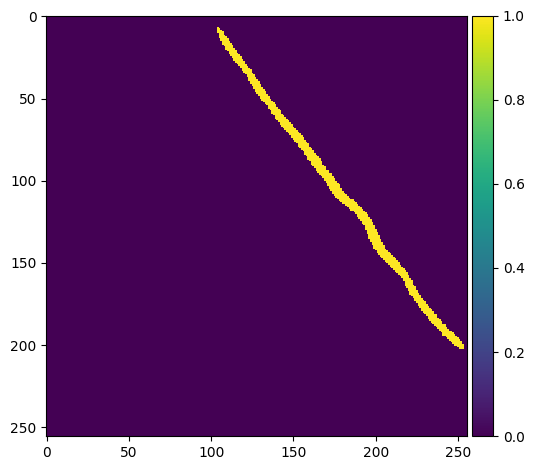

In [245]:
custom_objects = {"jacard_coef": jacard_coef}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model('models/unet_model_1.h5')


idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(test_dataset, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

15/15 [==============================] - 12s 816ms/step
(450, 256, 256, 1)


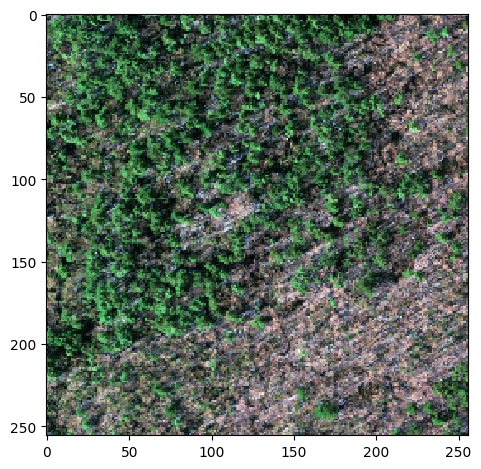

C:\Users\Mateo Echeverry\anaconda3\envs\hola\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


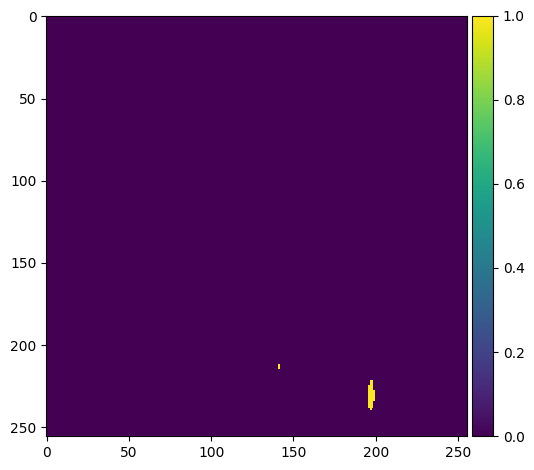

In [295]:
preds_test = model.predict(test_dataset, verbose=1)
print(preds_test.shape)
ix = random.randint(0, len(preds_test_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [319]:
submission = []
for i, pred in enumerate(preds_test):
    img_id = test_ids[i//64]
    # Format the image id
    id = img_id.split('_')[1].zfill(3)
    preds = split_into_patches(pred, 16)
    k = 0
    for j, img in enumerate(preds):
        print(j,img.shape)
        pix_x = j*16
        # Calculate the index of each subimage (in terms of pixels)
        x = 16*(5*((i % 64) % 8 ) + j % 5)
        y = 16*(5*((i % 64) // 8) + j // 5)
        # Don't add the padding predictions
        if x < 608 and y < 608:
            # For now we calculate the average over all the pixels and check if it's above 0.5
            submission.append((f"{id}_{x}_{y}", 1 if img.mean() > 0.5 else 0))
            if(x > xd):
                xd = x
np.savetxt("predictions.csv", np.asarray(submission), fmt="%s", delimiter=",", newline="\n", header="id,prediction", comments="")

0 (16, 16, 1)
1 (16, 16, 1)
2 (16, 16, 1)
3 (16, 16, 1)
4 (16, 16, 1)
5 (16, 16, 1)
6 (16, 16, 1)
7 (16, 16, 1)
8 (16, 16, 1)
9 (16, 16, 1)
10 (16, 16, 1)
11 (16, 16, 1)
12 (16, 16, 1)
13 (16, 16, 1)
14 (16, 16, 1)
15 (16, 16, 1)
16 (16, 16, 1)
17 (16, 16, 1)
18 (16, 16, 1)
19 (16, 16, 1)
20 (16, 16, 1)
21 (16, 16, 1)
22 (16, 16, 1)
23 (16, 16, 1)
24 (16, 16, 1)
25 (16, 16, 1)
26 (16, 16, 1)
27 (16, 16, 1)
28 (16, 16, 1)
29 (16, 16, 1)
30 (16, 16, 1)
31 (16, 16, 1)
32 (16, 16, 1)
33 (16, 16, 1)
34 (16, 16, 1)
35 (16, 16, 1)
36 (16, 16, 1)
37 (16, 16, 1)
38 (16, 16, 1)
39 (16, 16, 1)
40 (16, 16, 1)
41 (16, 16, 1)
42 (16, 16, 1)
43 (16, 16, 1)
44 (16, 16, 1)
45 (16, 16, 1)
46 (16, 16, 1)
47 (16, 16, 1)
48 (16, 16, 1)
49 (16, 16, 1)
50 (16, 16, 1)
51 (16, 16, 1)
52 (16, 16, 1)
53 (16, 16, 1)
54 (16, 16, 1)
55 (16, 16, 1)
56 (16, 16, 1)
57 (16, 16, 1)
58 (16, 16, 1)
59 (16, 16, 1)
60 (16, 16, 1)
61 (16, 16, 1)
62 (16, 16, 1)
63 (16, 16, 1)
64 (16, 16, 1)
65 (16, 16, 1)
66 (16, 16, 1)
67 (1